In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import imblearn

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Import of the training dataframe

In [2]:
train_df = pd.read_csv('./train.csv',
                 index_col='id')

train_df.drop_duplicates(inplace=True)

train_df.head(10)

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
id,,,,,,,,,,,,,,,,,,,,,
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived
5,no,adult,529642,38.1,56.0,32.0,normal,normal,bright_pink,less_3_sec,...,49.0,8.0,cloudy,2.8,no,0,0,0,yes,lived
6,yes,adult,534787,38.3,36.0,16.0,cool,reduced,normal_pink,less_3_sec,...,43.0,75.0,cloudy,1.0,no,3111,0,0,yes,euthanized
7,no,adult,529461,39.2,114.0,24.0,cool,reduced,pale_cyanotic,more_3_sec,...,57.0,7.6,serosanguious,4.5,yes,2207,0,0,yes,died
8,no,adult,528742,37.4,48.0,12.0,cool,reduced,normal_pink,less_3_sec,...,40.0,7.8,cloudy,2.6,no,0,0,0,yes,lived


In [3]:
train_df.info()

# The dataframe requires severe encoding as many columns are textual and need to be converted to numbers

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1235 entries, 0 to 1234
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   hospital_number        1235 non-null   int64  
 3   rectal_temp            1235 non-null   float64
 4   pulse                  1235 non-null   float64
 5   respiratory_rate       1235 non-null   float64
 6   temp_of_extremities    1235 non-null   object 
 7   peripheral_pulse       1235 non-null   object 
 8   mucous_membrane        1235 non-null   object 
 9   capillary_refill_time  1235 non-null   object 
 10  pain                   1235 non-null   object 
 11  peristalsis            1235 non-null   object 
 12  abdominal_distention   1235 non-null   object 
 13  nasogastric_tube       1235 non-null   object 
 14  nasogastric_reflux     1235 non-null   object 
 15  naso

### Let's have a look to the features to try and detect the possible correlation to the outcome column

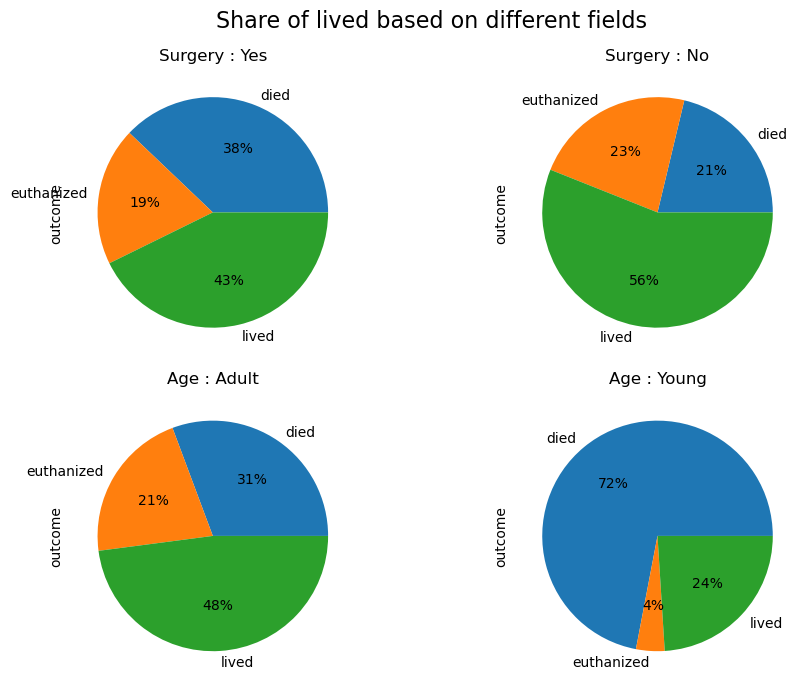

In [4]:
fig, ax = plt.subplots(2,2, figsize=(10,7))

fig.suptitle('Share of lived based on different fields', size=16)

pie0 = train_df[train_df['surgery']=='yes'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[0,0])
pie1 = train_df[train_df['surgery']=='no'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[0,1])
pie2 = train_df[train_df['age']=='adult'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[1,0])
pie3 = train_df[train_df['age']=='young'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[1,1])

ax[0,0].set(title='Surgery : Yes')
ax[0,1].set(title='Surgery : No')
ax[1,0].set(title='Age : Adult')
ax[1,1].set(title='Age : Young')


fig.tight_layout()

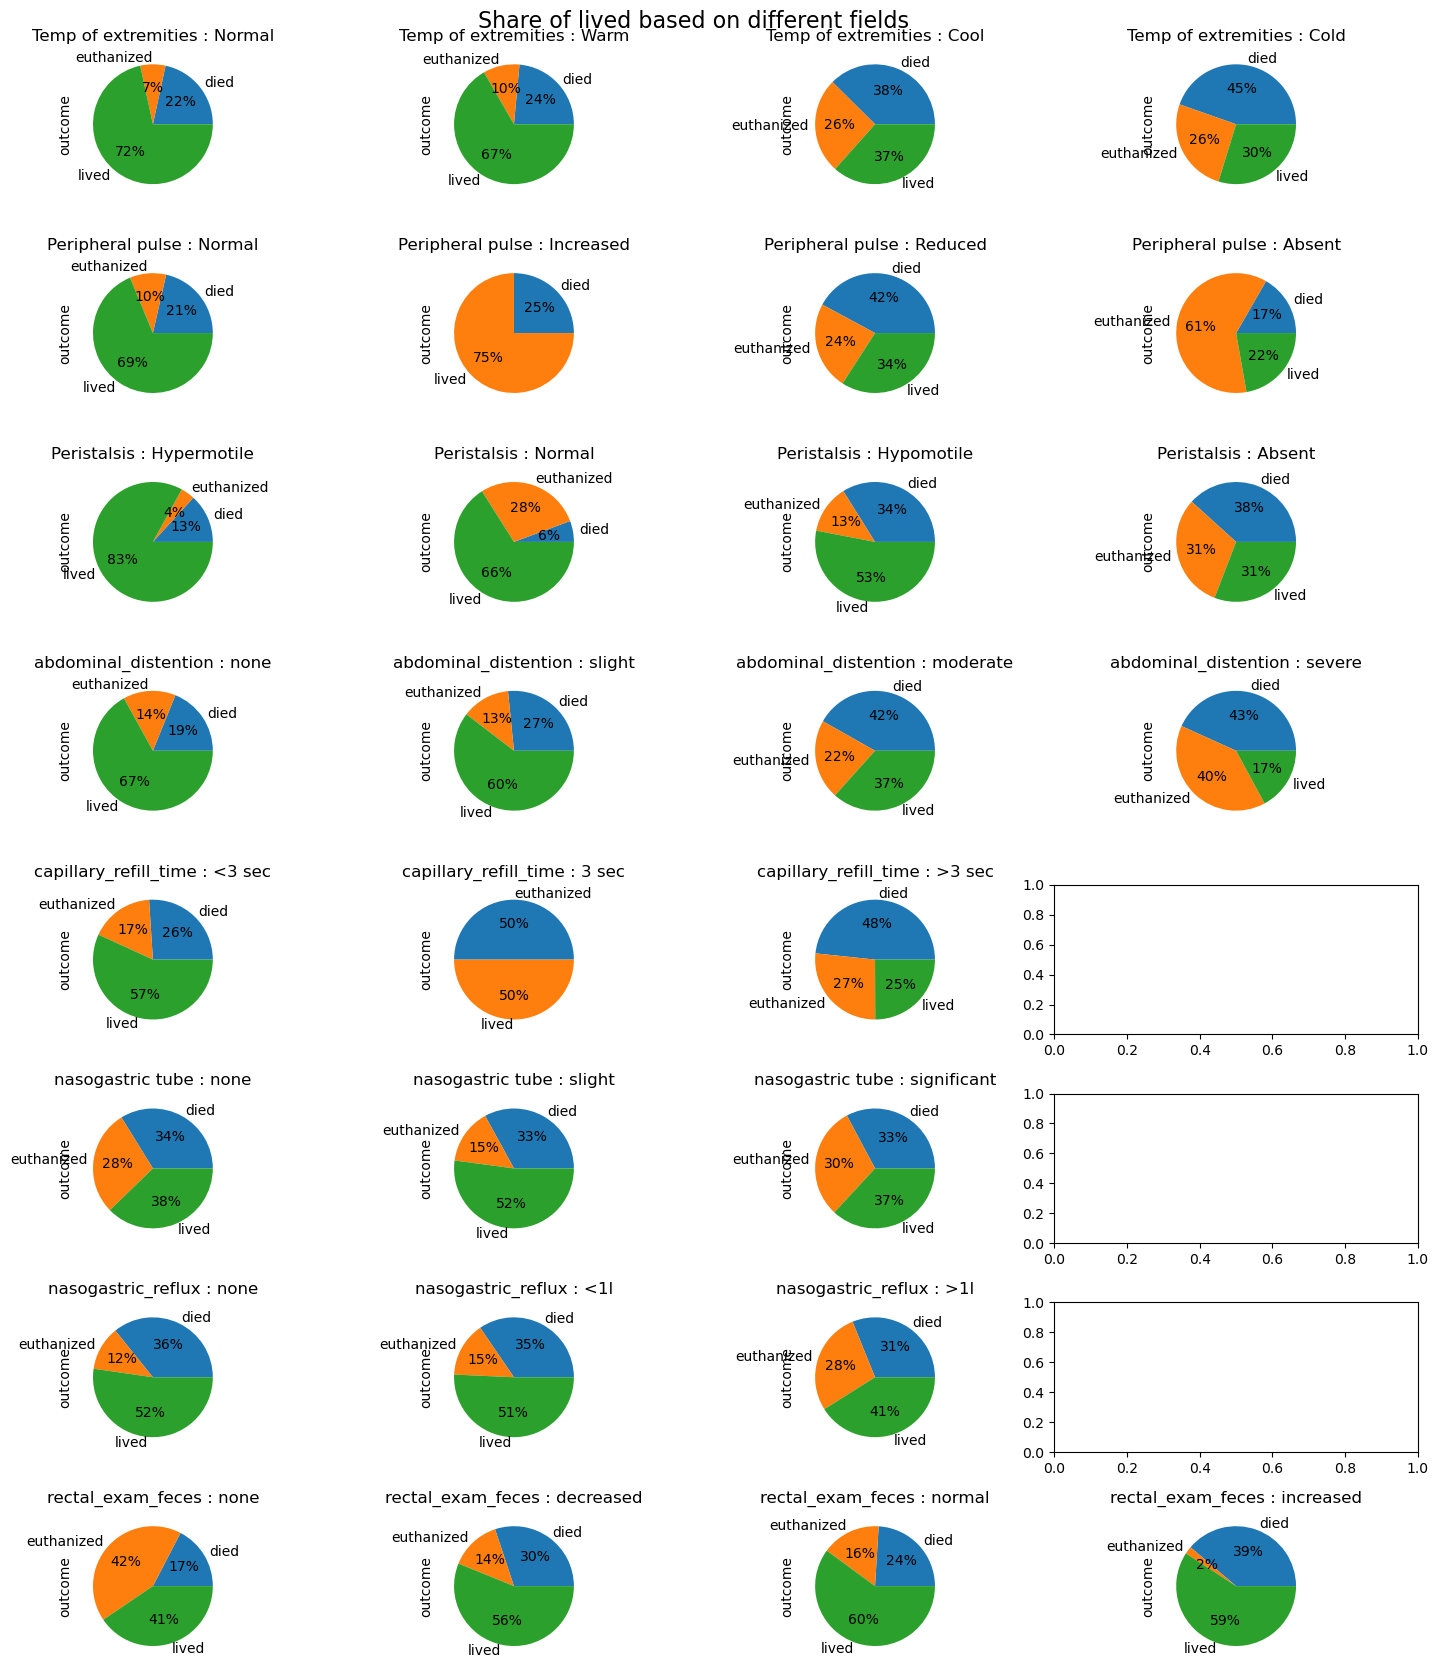

In [5]:
fig, ax = plt.subplots(nrows = 8,
                       ncols = 4, 
                       figsize=(15,17))

fig.suptitle('Share of lived based on different fields', size=16)

pie00 = train_df[train_df['temp_of_extremities']=='normal'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[0,0])
pie01 = train_df[train_df['temp_of_extremities']=='warm'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[0,1])
pie02 = train_df[train_df['temp_of_extremities']=='cool'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[0,2])
pie03 = train_df[train_df['temp_of_extremities']=='cold'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[0,3])

ax[0,0].set(title='Temp of extremities : Normal')
ax[0,1].set(title='Temp of extremities : Warm')
ax[0,2].set(title='Temp of extremities : Cool')
ax[0,3].set(title='Temp of extremities : Cold')

pie10 = train_df[train_df['peripheral_pulse']=='normal'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[1,0])
pie11 = train_df[train_df['peripheral_pulse']=='increased'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[1,1])
pie12 = train_df[train_df['peripheral_pulse']=='reduced'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[1,2])
pie13 = train_df[train_df['peripheral_pulse']=='absent'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[1,3])

ax[1,0].set(title='Peripheral pulse : Normal')
ax[1,1].set(title='Peripheral pulse : Increased')
ax[1,2].set(title='Peripheral pulse : Reduced')
ax[1,3].set(title='Peripheral pulse : Absent')


pie20 = train_df[train_df['peristalsis']=='hypermotile'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[2,0])
pie21 = train_df[train_df['peristalsis']=='normal'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[2,1])
pie22 = train_df[train_df['peristalsis']=='hypomotile'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[2,2])
pie23 = train_df[train_df['peristalsis']=='absent'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[2,3])

ax[2,0].set(title='Peristalsis : Hypermotile')
ax[2,1].set(title='Peristalsis : Normal')
ax[2,2].set(title='Peristalsis : Hypomotile')
ax[2,3].set(title='Peristalsis : Absent')


pie30 = train_df[train_df['abdominal_distention']=='none'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[3,0])
pie31 = train_df[train_df['abdominal_distention']=='slight'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[3,1])
pie32 = train_df[train_df['abdominal_distention']=='moderate'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[3,2])
pie33 = train_df[train_df['abdominal_distention']=='severe'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[3,3])

ax[3,0].set(title='abdominal_distention : none')
ax[3,1].set(title='abdominal_distention : slight')
ax[3,2].set(title='abdominal_distention : moderate')
ax[3,3].set(title='abdominal_distention : severe')


pie40 = train_df[train_df['capillary_refill_time']=='less_3_sec'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[4,0])
pie41 = train_df[train_df['capillary_refill_time']=='3'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[4,1])
pie42 = train_df[train_df['capillary_refill_time']=='more_3_sec'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[4,2])

ax[4,0].set(title='capillary_refill_time : <3 sec')
ax[4,1].set(title='capillary_refill_time : 3 sec')
ax[4,2].set(title='capillary_refill_time : >3 sec')

pie50 = train_df[((train_df['nasogastric_tube']=='None') | (train_df['nasogastric_tube']=='none')) ].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[5,0])
pie51 = train_df[train_df['nasogastric_tube']=='slight'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[5,1])
pie52 = train_df[train_df['nasogastric_tube']=='significant'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[5,2])

ax[5,0].set(title='nasogastric tube : none')
ax[5,1].set(title='nasogastric tube : slight')
ax[5,2].set(title='nasogastric tube : significant')


pie60 = train_df[((train_df['nasogastric_reflux']=='None') | (train_df['nasogastric_reflux']=='none')) ].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[6,0])
pie61 = train_df[train_df['nasogastric_reflux']=='less_1_liter'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[6,1])
pie62 = train_df[train_df['nasogastric_reflux']=='more_1_liter'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[6,2])

ax[6,0].set(title='nasogastric_reflux : none')
ax[6,1].set(title='nasogastric_reflux : <1l')
ax[6,2].set(title='nasogastric_reflux : >1l')


pie70 = train_df[((train_df['rectal_exam_feces']=='None') | (train_df['rectal_exam_feces']=='none')) ].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[7,0])
pie71 = train_df[train_df['rectal_exam_feces']=='decreased'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[7,1])
pie72 = train_df[train_df['rectal_exam_feces']=='normal'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[7,2])
pie73 = train_df[train_df['rectal_exam_feces']=='increased'].groupby(['outcome'])['outcome'].count().plot(kind='pie', y='outcome', autopct='%1.0f%%', ax=ax[7,3])

ax[7,0].set(title='rectal_exam_feces : none')
ax[7,1].set(title='rectal_exam_feces : decreased')
ax[7,2].set(title='rectal_exam_feces : normal')
ax[7,3].set(title='rectal_exam_feces : increased')


fig.tight_layout()

In [6]:
train_df.drop(train_df[train_df['rectal_exam_feces']=='serosanguious'].index, inplace=True)
train_df.drop(train_df[train_df['nasogastric_reflux']=='slight'].index, inplace=True)
train_df.drop(train_df[train_df['peristalsis']=='distend_small'].index, inplace=True)

### Some observations

* A couple of rows must be deleted because have abnormal values for `nasogastric_reflux` ("slight") and `rectal_exam_feces` ("serosanguious")
* "None" and "none" must be unified
* In general, I noticed that as symptoms become more evident there is an higher share of deceases or euthanised horses
* Apparently `Surgery`='Yes' has a larger share of deceased horses. Maybe this is because surgery is usually performed on the most critical cases, or maybe surgery is very risky?
* Apparently adult horses have an higher chance of survival vs younger ones
* The polarization of `rectal_exam_feces` is extremely useful to classify between euthanized and dead horses

### Let's see how much data is missing from each column

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1232 entries, 0 to 1234
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1232 non-null   object 
 1   age                    1232 non-null   object 
 2   hospital_number        1232 non-null   int64  
 3   rectal_temp            1232 non-null   float64
 4   pulse                  1232 non-null   float64
 5   respiratory_rate       1232 non-null   float64
 6   temp_of_extremities    1232 non-null   object 
 7   peripheral_pulse       1232 non-null   object 
 8   mucous_membrane        1232 non-null   object 
 9   capillary_refill_time  1232 non-null   object 
 10  pain                   1232 non-null   object 
 11  peristalsis            1232 non-null   object 
 12  abdominal_distention   1232 non-null   object 
 13  nasogastric_tube       1232 non-null   object 
 14  nasogastric_reflux     1232 non-null   object 
 15  naso

In [8]:
# Data is missing for some column, but we can fill it

for column in train_df.columns:
    print(train_df.groupby(column)[column].value_counts()/len(train_df))
    print('\n')

surgery  surgery
no       no         0.281656
yes      yes        0.718344
Name: surgery, dtype: float64


age    age  
adult  adult    0.939123
young  young    0.060877
Name: age, dtype: float64


hospital_number  hospital_number
521399           521399             0.002435
522979           522979             0.000812
523190           523190             0.001623
526639           526639             0.001623
526802           526802             0.002435
                                      ...   
5299253          5299253            0.001623
5299603          5299603            0.002435
5299629          5299629            0.004870
5301219          5301219            0.004058
5305129          5305129            0.000812
Name: hospital_number, Length: 255, dtype: float64


rectal_temp  rectal_temp
35.4         35.4           0.001623
36.0         36.0           0.004058
36.1         36.1           0.008929
36.2         36.2           0.000812
36.4         36.4           0.001623
36.5       

### Next steps:
* Transform all "None" present in the dataframe in na
* Fill in missing values
* Transform categorical in numerical variables
* Look at correlation and collinearity
* Look at the performance of baseline models

In [9]:
# "none" should be present only in abdominal_distension, nasogastric_tube, nasogastric_reflux, and lesion_1

train_df.columns[train_df.isin(['none']).any()] 
# This is ok, so I should change all the "None" into NAs so that I can fill them later

Index(['abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux'], dtype='object')

In [10]:
# I replace the None values with nan

train_df.replace('None', np.nan, inplace=True)

train_df.columns[train_df.isin(['None']).any()]


Index([], dtype='object')

<Axes: >

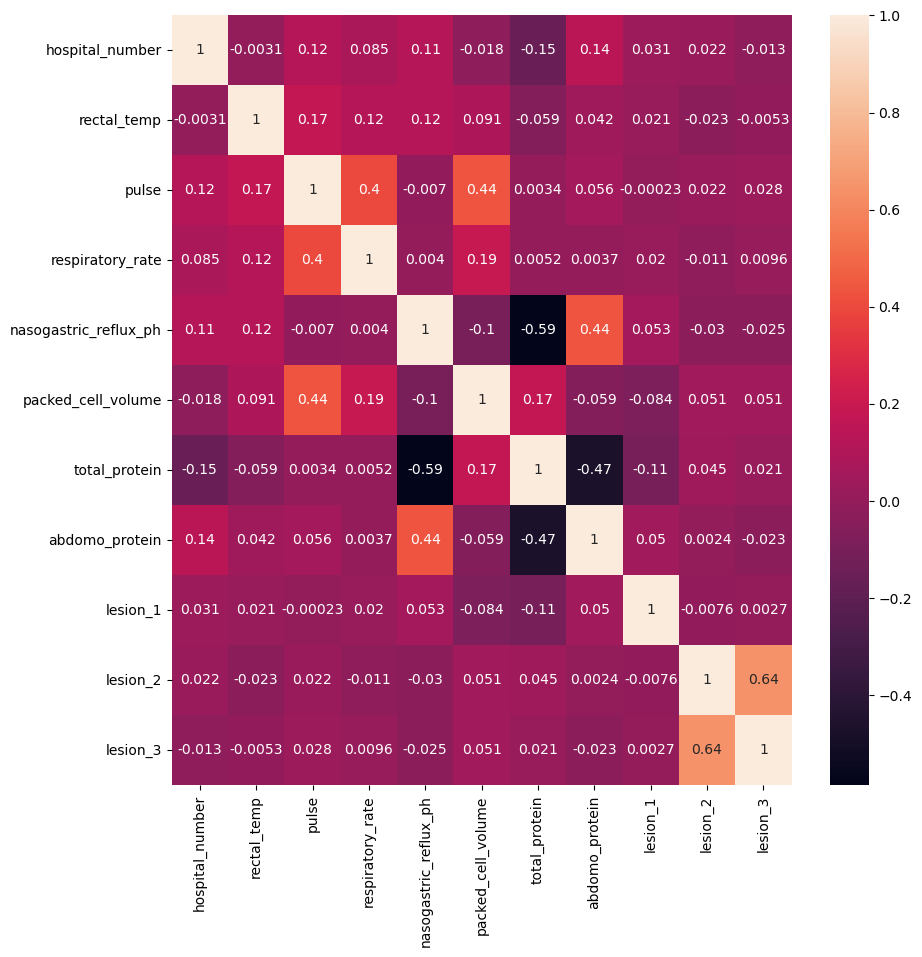

In [11]:
fig, ax = plt.subplots(figsize=(10,10))    
sns.heatmap(train_df.corr(numeric_only=True), annot=True)


### I will drop: 
* `respiratory_rate` (medium correlation with pulse)
* `temp_of_extremities` (should be subjective and highly correlated with rectal temp)
* `lesion_1`, `lesion_2`, `lesion_3`, `cp_data` (as these may be ex-post since the horse death)
* `nasogastric_reflux_ph` (high correlation with total_protein)
* `packed_cell_volume` (high correlation with pulse)
* `abdomo_protein` (high correlation with total_protein)
* `peripheral_pulse` (subjective) 
* `mucous_membrane` (subjective)
* `hospital_number` (simply an id)

https://www.kaggle.com/datasets/yasserh/horse-survival-dataset

In [12]:
train_df.drop(['respiratory_rate', 'temp_of_extremities', 'lesion_1', 'lesion_2', 'lesion_3', 'cp_data', 
               'nasogastric_reflux_ph', 'packed_cell_volume', 'abdomo_protein', 'peripheral_pulse', 'mucous_membrane','hospital_number'], 
              axis=1, 
              inplace=True)

<Axes: >

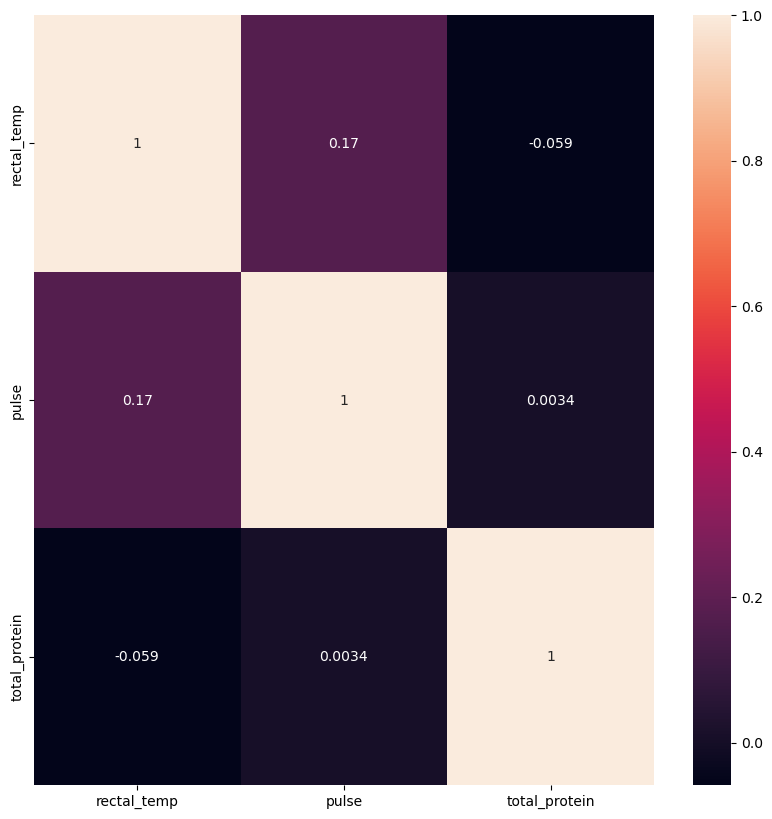

In [13]:
fig, ax = plt.subplots(figsize=(10,10))    
sns.heatmap(train_df.corr(numeric_only=True), annot=True)

In [14]:
# Splitting X and y

from sklearn.model_selection import train_test_split

X = train_df.drop('outcome', axis=1)
y = pd.DataFrame(train_df['outcome'], columns=['outcome'], index=train_df.index)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=25)

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1232 entries, 0 to 1234
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1232 non-null   object 
 1   age                    1232 non-null   object 
 2   rectal_temp            1232 non-null   float64
 3   pulse                  1232 non-null   float64
 4   capillary_refill_time  1226 non-null   object 
 5   pain                   1188 non-null   object 
 6   peristalsis            1212 non-null   object 
 7   abdominal_distention   1209 non-null   object 
 8   nasogastric_tube       1152 non-null   object 
 9   nasogastric_reflux     1211 non-null   object 
 10  rectal_exam_feces      1043 non-null   object 
 11  abdomen                1019 non-null   object 
 12  total_protein          1232 non-null   float64
 13  abdomo_appearance      1184 non-null   object 
 14  surgical_lesion        1232 non-null   object 
 15  outc

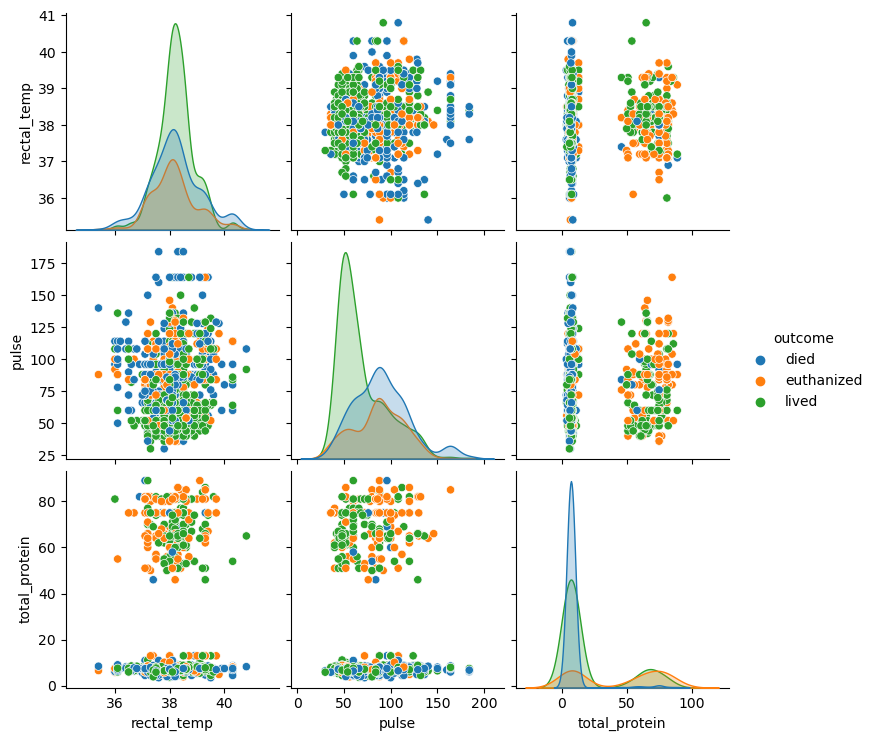

In [16]:
sns.pairplot(train_df, diag_kind='kde', hue='outcome')

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1232 entries, 0 to 1234
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1232 non-null   object 
 1   age                    1232 non-null   object 
 2   rectal_temp            1232 non-null   float64
 3   pulse                  1232 non-null   float64
 4   capillary_refill_time  1226 non-null   object 
 5   pain                   1188 non-null   object 
 6   peristalsis            1212 non-null   object 
 7   abdominal_distention   1209 non-null   object 
 8   nasogastric_tube       1152 non-null   object 
 9   nasogastric_reflux     1211 non-null   object 
 10  rectal_exam_feces      1043 non-null   object 
 11  abdomen                1019 non-null   object 
 12  total_protein          1232 non-null   float64
 13  abdomo_appearance      1184 non-null   object 
 14  surgical_lesion        1232 non-null   object 
 15  outc

In [18]:

input_cols = ['capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance']
num_cols = ['rectal_temp', 'pulse', 'total_protein']
cat_cols = ['surgery', 'age','surgical_lesion']
result_cols = ['outcome']


input_pipe = Pipeline([
    ('input', SimpleImputer(strategy='most_frequent')),
    ('ohe',OneHotEncoder(drop='first', sparse_output=False))    
])

enc_pipe = Pipeline([
    ('ohe',OneHotEncoder(drop='first', sparse_output=False))   
])

scal_pipe = Pipeline([
    ('minmax', MinMaxScaler())
])


ct = ColumnTransformer([
    ('inp', input_pipe, input_cols),
    ('enc', enc_pipe, cat_cols),
    ('sca', scal_pipe, num_cols)
    ], remainder='passthrough')

X_train_transf = pd.DataFrame(ct.fit_transform(X_train), 
                              index=X_train.index)
X_valid_transf = pd.DataFrame(ct.transform(X_valid), 
                              index=X_valid.index)

le = LabelEncoder()

y_train_transf = pd.DataFrame(le.fit_transform(np.ravel(y_train)), 
                              index=y_train.index)

y_valid_transf = pd.DataFrame(le.transform(np.ravel(y_valid)), 
                              index=y_valid.index)


In [19]:
models_dict = {
    'knn3' : KNeighborsClassifier(n_neighbors=3, metric='euclidean'),
    'knn5' : KNeighborsClassifier(n_neighbors=5, metric='euclidean'),
    'knn7' : KNeighborsClassifier(n_neighbors=7, metric='euclidean'),
    'knn9' : KNeighborsClassifier(n_neighbors=9, metric='euclidean'),
    'DtreeClass' : DecisionTreeClassifier(random_state=25),
    'RandfClass' : RandomForestClassifier(n_jobs=-1, random_state=25),
    'xgbClass' : XGBClassifier(n_jobs=-1, objective='multi:softmax')
}

results_df = pd.DataFrame(index=models_dict.keys(), columns=['prec_VAL','prec_TRA', 'rec_VAL', 'rec_TRA', 'f1_VAL', 'f1_TRA'])

results_df


for k, v in models_dict.items():
    v.fit(X_train_transf, np.ravel(y_train_transf))
    y_preds_train = v.predict(X_train_transf)
    y_preds_valid = v.predict(X_valid_transf)
    
    results_df.loc[k, 'prec_TRA'] = precision_score(y_preds_train, y_train_transf, average='weighted')
    results_df.loc[k, 'prec_VAL'] = precision_score(y_preds_valid, y_valid_transf, average='weighted')
    
    results_df.loc[k, 'rec_TRA'] = recall_score(y_preds_train, y_train_transf, average='weighted')
    results_df.loc[k, 'rec_VAL'] = recall_score(y_preds_valid, y_valid_transf, average='weighted')
    
    results_df.loc[k, 'f1_TRA'] = f1_score(y_preds_train, y_train_transf, average='micro')
    results_df.loc[k, 'f1_VAL'] = f1_score(y_preds_valid, y_valid_transf, average='micro')
    

results_df
    

,prec_VAL,prec_TRA,rec_VAL,rec_TRA,f1_VAL,f1_TRA
knn3,0.583439,0.785282,0.566802,0.760406,0.566802,0.760406
knn5,0.550484,0.760747,0.54251,0.742132,0.54251,0.742132
knn7,0.58312,0.750166,0.562753,0.726904,0.562753,0.726904
knn9,0.628076,0.747003,0.595142,0.713706,0.595142,0.713706
DtreeClass,0.580996,0.997975,0.574899,0.99797,0.574899,0.99797
RandfClass,0.649044,0.997975,0.643725,0.99797,0.643725,0.99797
xgbClass,0.624547,0.997975,0.619433,0.99797,0.619433,0.99797


### I would try and improve the RandomForestClassifier model, which is clearly in overfitting.
I need to increase bias and reduce variance. To do this I might try to:

* Reduce overfitting by taking action on the `max_depth`, `min_samples_leaf` or other hyperparameters, using `GridSearchCV`
* Drop some features, to try and simplify the model

Let's start with GridSearchCV and let's see the change in model performance

In [20]:
prm_grid = {
    'random_state' : [25],
    'max_depth' : [None, 3, 5, 7, 9],
    'n_estimators' : [50, 100, 120, 150]
    }

clf = RandomForestClassifier()

gscv = GridSearchCV(clf, 
                    param_grid = prm_grid,
                    n_jobs = -1,
                    cv = 5,
                    scoring='f1_micro')

gscv.fit(X_train_transf, np.ravel(y_train_transf))

gscv.best_params_

{'max_depth': 9, 'n_estimators': 120, 'random_state': 25}

In [21]:
print('CLASSIFICATION_REPORT - TRAINING')
print('\n')
print(classification_report(y_train_transf, gscv.best_estimator_.predict(X_train_transf)))

print('\n')

print('CLASSIFICATION_REPORT - VALIDATION')
print('\n')
print(classification_report(y_valid_transf, gscv.best_estimator_.predict(X_valid_transf)))

CLASSIFICATION_REPORT - TRAINING


              precision    recall  f1-score   support

           0       0.84      0.90      0.87       328
           1       0.97      0.81      0.89       200
           2       0.90      0.91      0.91       457

    accuracy                           0.89       985
   macro avg       0.90      0.88      0.89       985
weighted avg       0.89      0.89      0.89       985



CLASSIFICATION_REPORT - VALIDATION


              precision    recall  f1-score   support

           0       0.61      0.63      0.62        82
           1       0.66      0.50      0.57        50
           2       0.67      0.72      0.69       115

    accuracy                           0.65       247
   macro avg       0.65      0.62      0.63       247
weighted avg       0.65      0.65      0.65       247



In [22]:
prm_grid = {
    'random_state' : [25],
    'max_depth' : [5],
    'n_estimators' : [120]
    }

clf = RandomForestClassifier()

gscv = GridSearchCV(clf, 
                    param_grid = prm_grid,
                    n_jobs = -1,
                    cv = 5,
                    scoring='f1_micro')

gscv.fit(X_train_transf, np.ravel(y_train_transf))

gscv.best_params_

{'max_depth': 5, 'n_estimators': 120, 'random_state': 25}

In [23]:
print('CLASSIFICATION_REPORT - TRAINING')
print('\n')
print(classification_report(y_train_transf, gscv.best_estimator_.predict(X_train_transf)))

print('\n')

print('CLASSIFICATION_REPORT - VALIDATION')
print('\n')
print(classification_report(y_valid_transf, gscv.best_estimator_.predict(X_valid_transf)))

CLASSIFICATION_REPORT - TRAINING


              precision    recall  f1-score   support

           0       0.69      0.79      0.74       328
           1       0.80      0.52      0.63       200
           2       0.77      0.81      0.79       457

    accuracy                           0.74       985
   macro avg       0.76      0.71      0.72       985
weighted avg       0.75      0.74      0.74       985



CLASSIFICATION_REPORT - VALIDATION


              precision    recall  f1-score   support

           0       0.64      0.71      0.67        82
           1       0.62      0.40      0.49        50
           2       0.68      0.73      0.70       115

    accuracy                           0.66       247
   macro avg       0.65      0.61      0.62       247
weighted avg       0.65      0.66      0.65       247



In [24]:
prm_grid = {
    'random_state' : [25],
    'max_depth' : [5],
    'n_estimators' : [120],
    'max_features' : [0.3, 0.5, 0.7]
    }

clf = RandomForestClassifier()

gscv = GridSearchCV(clf, 
                    param_grid = prm_grid,
                    n_jobs = -1,
                    cv = 5,
                    scoring='f1_micro')

gscv.fit(X_train_transf, np.ravel(y_train_transf))

gscv.best_params_

{'max_depth': 5, 'max_features': 0.5, 'n_estimators': 120, 'random_state': 25}

In [25]:
print('CLASSIFICATION_REPORT - TRAINING')
print('\n')
print(classification_report(y_train_transf, gscv.best_estimator_.predict(X_train_transf)))

print('\n')

print('CLASSIFICATION_REPORT - VALIDATION')
print('\n')
print(classification_report(y_valid_transf, gscv.best_estimator_.predict(X_valid_transf)))

CLASSIFICATION_REPORT - TRAINING


              precision    recall  f1-score   support

           0       0.68      0.83      0.74       328
           1       0.78      0.56      0.65       200
           2       0.81      0.78      0.80       457

    accuracy                           0.75       985
   macro avg       0.75      0.72      0.73       985
weighted avg       0.76      0.75      0.75       985



CLASSIFICATION_REPORT - VALIDATION


              precision    recall  f1-score   support

           0       0.63      0.71      0.67        82
           1       0.65      0.48      0.55        50
           2       0.70      0.72      0.71       115

    accuracy                           0.67       247
   macro avg       0.66      0.64      0.64       247
weighted avg       0.67      0.67      0.66       247



In [26]:
prm_grid = {
    'random_state' : [25],
    'max_depth' : [5],
    'n_estimators' : [120],
    'max_features' : [0.5]
    }

clf = RandomForestClassifier()

gscv = GridSearchCV(clf, 
                    param_grid = prm_grid,
                    n_jobs = -1,
                    cv = 5,
                    scoring='f1_micro')

gscv.fit(X_train_transf, np.ravel(y_train_transf))

gscv.best_params_

{'max_depth': 5, 'max_features': 0.5, 'n_estimators': 120, 'random_state': 25}

In [27]:
print('CLASSIFICATION_REPORT - TRAINING')
print('\n')
print(classification_report(y_train_transf, gscv.best_estimator_.predict(X_train_transf)))

print('\n')

print('CLASSIFICATION_REPORT - VALIDATION')
print('\n')
print(classification_report(y_valid_transf, gscv.best_estimator_.predict(X_valid_transf)))

CLASSIFICATION_REPORT - TRAINING


              precision    recall  f1-score   support

           0       0.68      0.83      0.74       328
           1       0.78      0.56      0.65       200
           2       0.81      0.78      0.80       457

    accuracy                           0.75       985
   macro avg       0.75      0.72      0.73       985
weighted avg       0.76      0.75      0.75       985



CLASSIFICATION_REPORT - VALIDATION


              precision    recall  f1-score   support

           0       0.63      0.71      0.67        82
           1       0.65      0.48      0.55        50
           2       0.70      0.72      0.71       115

    accuracy                           0.67       247
   macro avg       0.66      0.64      0.64       247
weighted avg       0.67      0.67      0.66       247



#### By playing with hyperparameters I managed to reduce variance by improving bias by a couple of pp.
Anyway, I notice there is high class imbalance in y, so I might try to:

* Increase the number of samples (using random oversampling or also SMOTE)?

In [28]:
oversample = imblearn.over_sampling.SMOTE()
X_train_transf, y_train_transf = oversample.fit_resample(X_train_transf, y_train_transf)

In [32]:
models_dict = {
    'knn3' : KNeighborsClassifier(n_neighbors=3, metric='euclidean'),
    'knn5' : KNeighborsClassifier(n_neighbors=5, metric='euclidean'),
    'knn7' : KNeighborsClassifier(n_neighbors=7, metric='euclidean'),
    'knn9' : KNeighborsClassifier(n_neighbors=9, metric='euclidean'),
    'DtreeClass' : DecisionTreeClassifier(random_state=25),
    'RandfClass' : RandomForestClassifier(random_state =25),
    'xgbClass' : XGBClassifier(n_jobs=-1, objective='multi:softmax')
}

results_df = pd.DataFrame(index=models_dict.keys(), columns=['prec_VAL','prec_TRA', 'rec_VAL', 'rec_TRA', 'f1_VAL', 'f1_TRA'])

results_df


for k, v in models_dict.items():
    v.fit(X_train_transf, np.ravel(y_train_transf))
    y_preds_train = v.predict(X_train_transf)
    y_preds_valid = v.predict(X_valid_transf)
    
    results_df.loc[k, 'prec_TRA'] = precision_score(y_preds_train, y_train_transf, average='weighted')
    results_df.loc[k, 'prec_VAL'] = precision_score(y_preds_valid, y_valid_transf, average='weighted')
    
    results_df.loc[k, 'rec_TRA'] = recall_score(y_preds_train, y_train_transf, average='weighted')
    results_df.loc[k, 'rec_VAL'] = recall_score(y_preds_valid, y_valid_transf, average='weighted')
    
    results_df.loc[k, 'f1_TRA'] = f1_score(y_preds_train, y_train_transf, average='micro')
    results_df.loc[k, 'f1_VAL'] = f1_score(y_preds_valid, y_valid_transf, average='micro')
    

results_df
    

,prec_VAL,prec_TRA,rec_VAL,rec_TRA,f1_VAL,f1_TRA
knn3,0.516654,0.876437,0.526316,0.858497,0.526316,0.858497
knn5,0.51035,0.822886,0.51417,0.803063,0.51417,0.803063
knn7,0.489436,0.787904,0.497976,0.766594,0.497976,0.766594
knn9,0.503973,0.768761,0.51417,0.752735,0.51417,0.752735
DtreeClass,0.566258,0.998543,0.562753,0.998541,0.562753,0.998541
RandfClass,0.602335,0.998548,0.603239,0.998541,0.603239,0.998541
xgbClass,0.589215,0.998543,0.587045,0.998541,0.587045,0.998541


### Let's try again improving the performance of RandomForestClassifier by reducing variance

In [77]:
prm_grid = {
    'random_state' : [25],
    'max_depth' : [3],
    'n_estimators' : [150],
    'max_features' : [0.4]
    }

clf = RandomForestClassifier()

gscv = GridSearchCV(clf, 
                    param_grid = prm_grid,
                    n_jobs = -1,
                    cv = 5,
                    scoring='f1_micro')

gscv.fit(X_train_transf, np.ravel(y_train_transf))

gscv.best_params_

{'max_depth': 3, 'max_features': 0.4, 'n_estimators': 150, 'random_state': 25}

In [78]:
print('CLASSIFICATION_REPORT - TRAINING')
print('\n')
print(classification_report(y_train_transf, gscv.best_estimator_.predict(X_train_transf)))

print('\n')

print('CLASSIFICATION_REPORT - VALIDATION')
print('\n')
print(classification_report(y_valid_transf, gscv.best_estimator_.predict(X_valid_transf)))

CLASSIFICATION_REPORT - TRAINING


              precision    recall  f1-score   support

           0       0.64      0.83      0.72       457
           1       0.79      0.66      0.72       457
           2       0.75      0.65      0.69       457

    accuracy                           0.71      1371
   macro avg       0.73      0.71      0.71      1371
weighted avg       0.73      0.71      0.71      1371



CLASSIFICATION_REPORT - VALIDATION


              precision    recall  f1-score   support

           0       0.61      0.83      0.70        82
           1       0.61      0.54      0.57        50
           2       0.78      0.63      0.70       115

    accuracy                           0.68       247
   macro avg       0.67      0.67      0.66       247
weighted avg       0.69      0.68      0.67       247



With this configuration for RandomForestClassifier I obtain a reasonable reduction of variance  {
    'random_state' : [25],
    'max_depth' : [3],
    'n_estimators' : [150],
    'max_features' : [0.4]
    }

Let's try improving xgboost classifier

In [116]:
prm_grid = {
    'booster' : ['gbtree'],
    'max_depth' : [7],
    'random_state' : [25],
    'subsample' : [0.05],
    'eta' : [0.02]}

clf = XGBClassifier()

gscv = GridSearchCV(clf, 
                    param_grid = prm_grid,
                    n_jobs = -1,
                    cv = 5,
                    scoring='f1_micro')

gscv.fit(X_train_transf, np.ravel(y_train_transf))

gscv.best_params_

{'booster': 'gbtree',
 'eta': 0.02,
 'max_depth': 7,
 'random_state': 25,
 'subsample': 0.05}

In [117]:
print('CLASSIFICATION_REPORT - TRAINING')
print('\n')
print(classification_report(y_train_transf, gscv.best_estimator_.predict(X_train_transf)))

print('\n')

print('CLASSIFICATION_REPORT - VALIDATION')
print('\n')
print(classification_report(y_valid_transf, gscv.best_estimator_.predict(X_valid_transf)))

CLASSIFICATION_REPORT - TRAINING


              precision    recall  f1-score   support

           0       0.69      0.77      0.73       457
           1       0.76      0.76      0.76       457
           2       0.73      0.65      0.69       457

    accuracy                           0.73      1371
   macro avg       0.73      0.73      0.73      1371
weighted avg       0.73      0.73      0.73      1371



CLASSIFICATION_REPORT - VALIDATION


              precision    recall  f1-score   support

           0       0.61      0.74      0.67        82
           1       0.60      0.66      0.63        50
           2       0.77      0.62      0.69       115

    accuracy                           0.67       247
   macro avg       0.66      0.67      0.66       247
weighted avg       0.68      0.67      0.67       247



### Both XGBoostClassifier and RandomForestClassifier bring similar results. I want to look at features again, and see if excluding additional ones helps me to improve the models performance 

In [134]:
train_df = pd.read_csv('./train.csv',
                 index_col='id')

train_df.drop_duplicates(inplace=True)

train_df.head(10)

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
id,,,,,,,,,,,,,,,,,,,,,
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived
5,no,adult,529642,38.1,56.0,32.0,normal,normal,bright_pink,less_3_sec,...,49.0,8.0,cloudy,2.8,no,0,0,0,yes,lived
6,yes,adult,534787,38.3,36.0,16.0,cool,reduced,normal_pink,less_3_sec,...,43.0,75.0,cloudy,1.0,no,3111,0,0,yes,euthanized
7,no,adult,529461,39.2,114.0,24.0,cool,reduced,pale_cyanotic,more_3_sec,...,57.0,7.6,serosanguious,4.5,yes,2207,0,0,yes,died
8,no,adult,528742,37.4,48.0,12.0,cool,reduced,normal_pink,less_3_sec,...,40.0,7.8,cloudy,2.6,no,0,0,0,yes,lived


In [135]:
train_df.drop(train_df[train_df['rectal_exam_feces']=='serosanguious'].index, inplace=True)
train_df.drop(train_df[train_df['nasogastric_reflux']=='slight'].index, inplace=True)
train_df.drop(train_df[train_df['peristalsis']=='distend_small'].index, inplace=True)

train_df.replace('None', np.nan, inplace=True)

train_df.columns[train_df.isin(['None']).any()]

Index([], dtype='object')

In [136]:
train_df.drop(['temp_of_extremities', 'lesion_1', 'lesion_2', 'lesion_3', 'cp_data', 
               'nasogastric_reflux_ph', 'packed_cell_volume', 'abdomo_protein','hospital_number'], 
              axis=1, 
              inplace=True)


X = train_df.drop('outcome', axis=1)
y = pd.DataFrame(train_df['outcome'], columns=['outcome'], index=train_df.index)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=25)

In [137]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1232 entries, 0 to 1234
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1232 non-null   object 
 1   age                    1232 non-null   object 
 2   rectal_temp            1232 non-null   float64
 3   pulse                  1232 non-null   float64
 4   respiratory_rate       1232 non-null   float64
 5   peripheral_pulse       1172 non-null   object 
 6   mucous_membrane        1211 non-null   object 
 7   capillary_refill_time  1226 non-null   object 
 8   pain                   1188 non-null   object 
 9   peristalsis            1212 non-null   object 
 10  abdominal_distention   1209 non-null   object 
 11  nasogastric_tube       1152 non-null   object 
 12  nasogastric_reflux     1211 non-null   object 
 13  rectal_exam_feces      1043 non-null   object 
 14  abdomen                1019 non-null   object 
 15  tota

In [138]:

input_cols = ['peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance']
num_cols = ['rectal_temp', 'pulse', 'respiratory_rate','total_protein']
cat_cols = ['surgery', 'age','surgical_lesion']
result_cols = ['outcome']


input_pipe = Pipeline([
    ('input', SimpleImputer(strategy='most_frequent')),
    ('ohe',OneHotEncoder(drop='first', sparse_output=False))    
])

enc_pipe = Pipeline([
    ('ohe',OneHotEncoder(drop='first', sparse_output=False))   
])

scal_pipe = Pipeline([
    ('minmax', MinMaxScaler())
])


ct = ColumnTransformer([
    ('inp', input_pipe, input_cols),
    ('enc', enc_pipe, cat_cols),
    ('sca', scal_pipe, num_cols)
    ], remainder='passthrough')

X_train_transf = pd.DataFrame(ct.fit_transform(X_train), 
                              index=X_train.index)
X_valid_transf = pd.DataFrame(ct.transform(X_valid), 
                              index=X_valid.index)

le = LabelEncoder()

y_train_transf = pd.DataFrame(le.fit_transform(np.ravel(y_train)), 
                              index=y_train.index)

y_valid_transf = pd.DataFrame(le.transform(np.ravel(y_valid)), 
                              index=y_valid.index)


In [139]:
oversample = imblearn.over_sampling.SMOTE()
X_train_transf, y_train_transf = oversample.fit_resample(X_train_transf, y_train_transf)

In [140]:
models_dict = {
    'knn3' : KNeighborsClassifier(n_neighbors=3, metric='euclidean'),
    'knn5' : KNeighborsClassifier(n_neighbors=5, metric='euclidean'),
    'knn7' : KNeighborsClassifier(n_neighbors=7, metric='euclidean'),
    'knn9' : KNeighborsClassifier(n_neighbors=9, metric='euclidean'),
    'DtreeClass' : DecisionTreeClassifier(random_state=25),
    'RandfClass' : RandomForestClassifier(random_state =25),
    'xgbClass' : XGBClassifier(n_jobs=-1, objective='multi:softmax')
}

results_df = pd.DataFrame(index=models_dict.keys(), columns=['prec_VAL','prec_TRA', 'rec_VAL', 'rec_TRA', 'f1_VAL', 'f1_TRA'])

results_df


for k, v in models_dict.items():
    v.fit(X_train_transf, np.ravel(y_train_transf))
    y_preds_train = v.predict(X_train_transf)
    y_preds_valid = v.predict(X_valid_transf)
    
    results_df.loc[k, 'prec_TRA'] = precision_score(y_preds_train, y_train_transf, average='weighted')
    results_df.loc[k, 'prec_VAL'] = precision_score(y_preds_valid, y_valid_transf, average='weighted')
    
    results_df.loc[k, 'rec_TRA'] = recall_score(y_preds_train, y_train_transf, average='weighted')
    results_df.loc[k, 'rec_VAL'] = recall_score(y_preds_valid, y_valid_transf, average='weighted')
    
    results_df.loc[k, 'f1_TRA'] = f1_score(y_preds_train, y_train_transf, average='micro')
    results_df.loc[k, 'f1_VAL'] = f1_score(y_preds_valid, y_valid_transf, average='micro')
    

results_df
    

,prec_VAL,prec_TRA,rec_VAL,rec_TRA,f1_VAL,f1_TRA
knn3,0.502322,0.878376,0.497976,0.851204,0.497976,0.851204
knn5,0.531479,0.834496,0.526316,0.793581,0.526316,0.793581
knn7,0.560393,0.801713,0.550607,0.768782,0.550607,0.768782
knn9,0.545808,0.774339,0.526316,0.743982,0.526316,0.743982
DtreeClass,0.540514,0.999272,0.54251,0.999271,0.54251,0.999271
RandfClass,0.644845,0.999272,0.643725,0.999271,0.643725,0.999271
xgbClass,0.60673,0.999272,0.607287,0.999271,0.607287,0.999271


In [182]:
prm_grid = {
    'random_state' : [25],
    'max_depth' : [6],
    'n_estimators' : [100]
    }

clf = RandomForestClassifier()

gscv = GridSearchCV(clf, 
                    param_grid = prm_grid,
                    n_jobs = -1,
                    cv = 5,
                    scoring='f1_micro')

gscv.fit(X_train_transf, np.ravel(y_train_transf))

gscv.best_params_

{'max_depth': 6, 'n_estimators': 100, 'random_state': 25}

In [183]:
print('CLASSIFICATION_REPORT - TRAINING')
print('\n')
print(classification_report(y_train_transf, gscv.best_estimator_.predict(X_train_transf)))

print('\n')

print('CLASSIFICATION_REPORT - VALIDATION')
print('\n')
print(classification_report(y_valid_transf, gscv.best_estimator_.predict(X_valid_transf)))

CLASSIFICATION_REPORT - TRAINING


              precision    recall  f1-score   support

           0       0.74      0.88      0.80       457
           1       0.85      0.81      0.83       457
           2       0.84      0.71      0.77       457

    accuracy                           0.80      1371
   macro avg       0.81      0.80      0.80      1371
weighted avg       0.81      0.80      0.80      1371



CLASSIFICATION_REPORT - VALIDATION


              precision    recall  f1-score   support

           0       0.62      0.74      0.67        82
           1       0.63      0.66      0.65        50
           2       0.76      0.63      0.69       115

    accuracy                           0.68       247
   macro avg       0.67      0.68      0.67       247
weighted avg       0.69      0.68      0.68       247

